# Querying the Las Cumbres Database for Outside Temperatures at 

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define your query parameters
site = 'lsc'  # Example: 'ogg' for Hawaii, 'cpt' for South Africa, etc.

# 'Weather Air Temperature Value':  Ambient temperature measured by HMP45C-L temperature probe at the site’s weather station.
# See https://developers.lco.global/#retrieve-weather for other available datum names
datumname1 = 'Weather Air Temperature Value' 
datumLabel1 = 'Temperature'
datumname2 = 'Boltwood Sky Minus Ambient Temperature'
datumLabel2 = 'Cloudiness'

date_range = 400.
date_interval = 20. 

In [3]:
n_steps = int(date_range/date_interval)

In [4]:
end_time_0 = datetime.utcnow()
end_time = end_time_0

/tmp/ipykernel_1391/2331444362.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time_0 = datetime.utcnow()


In [5]:
df_list = []

In [6]:
for n in range(n_steps + 1):

    start_time = end_time - timedelta(days=date_interval)

    print(n, start_time, end_time)

    start = start_time.isoformat(timespec='seconds') + 'Z' # Add 'Z' for UTC
    end = end_time.isoformat(timespec='seconds') + 'Z'

    # Construct the URL
    url = f'https://weather-api.lco.global/query?site={site}&datumname={datumname1}&start={start}&end={end}'

    # Run query
    data = None
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        data = response.json()
        #print(data)
    except requests.exceptions.RequestException as e:
        print(f"Error making request: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response content: {e.response.text}")


    # Convert results to pandas dataframe
    
    if data: # Ensure data was successfully fetched
    
        try:
            df = pd.DataFrame(data)

            # Assuming the JSON structure is a list of dictionaries,
            # where each dictionary represents a data point.
            # Common keys might be 'timestamp', 'value', 'units', etc.

            # Example: Convert 'timestamp' column to datetime objects
            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])

            # Example: Set 'timestamp' as the index (optional, but often useful for time series)
            if 'timestamp' in df.columns:
                df = df.set_index('timestamp')

            if 'Value' in df.columns:
                df = df.rename(columns={'Value': datumLabel1})
            
            #print(df.head()) # Display the first few rows of the DataFrame
            #print(df.info()) # Get a summary of the DataFrame

            df_list.append(df)

        except Exception as e:
            print(f"Error converting JSON to DataFrame: {e}")
            # It's helpful to print the structure of 'data' here if conversion fails
            print(f"Structure of data: {type(data)} - {data[:2] if isinstance(data, list) else data}")

    else:
        print("No data received from the API to convert to DataFrame.")

    end_time = start_time

if len(df_list) > 1:
    df_all_1 = pd.concat(df_list, ignore_index=True)
elif len(df_list) == 1:
    df_all_1 = df_list[0]
else:
    print("No DataFrames to concatenate.")
    df_all_1 = None

0 2025-05-09 22:49:42.024955 2025-05-29 22:49:42.024955
1 2025-04-19 22:49:42.024955 2025-05-09 22:49:42.024955
2 2025-03-30 22:49:42.024955 2025-04-19 22:49:42.024955
3 2025-03-10 22:49:42.024955 2025-03-30 22:49:42.024955
4 2025-02-18 22:49:42.024955 2025-03-10 22:49:42.024955
5 2025-01-29 22:49:42.024955 2025-02-18 22:49:42.024955
6 2025-01-09 22:49:42.024955 2025-01-29 22:49:42.024955
7 2024-12-20 22:49:42.024955 2025-01-09 22:49:42.024955
8 2024-11-30 22:49:42.024955 2024-12-20 22:49:42.024955
9 2024-11-10 22:49:42.024955 2024-11-30 22:49:42.024955
10 2024-10-21 22:49:42.024955 2024-11-10 22:49:42.024955
11 2024-10-01 22:49:42.024955 2024-10-21 22:49:42.024955
12 2024-09-11 22:49:42.024955 2024-10-01 22:49:42.024955
13 2024-08-22 22:49:42.024955 2024-09-11 22:49:42.024955
14 2024-08-02 22:49:42.024955 2024-08-22 22:49:42.024955
15 2024-07-13 22:49:42.024955 2024-08-02 22:49:42.024955
16 2024-06-23 22:49:42.024955 2024-07-13 22:49:42.024955
17 2024-06-03 22:49:42.024955 2024-06-23 

In [7]:
if df_all_1 is not None:
    display(df_all_1.head())

,TimeStamp,Temperature,ValueString,TimeStampMeasured
0,2025/05/09 22:45:00,14.910000,,2025/05/09 22:45:00
1,2025/05/09 23:00:00,15.373333,,2025/05/09 23:00:00
2,2025/05/09 23:15:00,15.350000,,2025/05/09 23:15:00
3,2025/05/09 23:30:00,15.405556,,2025/05/09 23:30:00
4,2025/05/09 23:45:00,15.445455,,2025/05/09 23:45:00


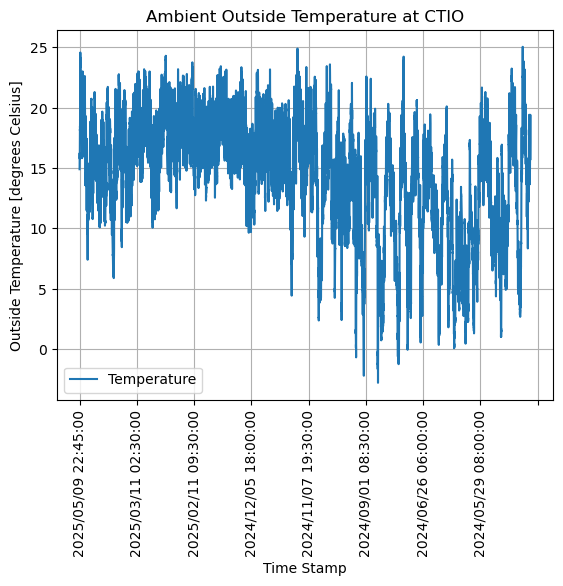

In [8]:
if df_all_1 is not None:
    df_all_1.plot('TimeStamp', datumLabel1)
    plt.title('Ambient Outside Temperature at CTIO')
    plt.xticks(rotation=90) # This is the key line!
    plt.xlabel('Time Stamp')
    plt.ylabel('Outside Temperature [degrees Celsius]')
    plt.grid(True)

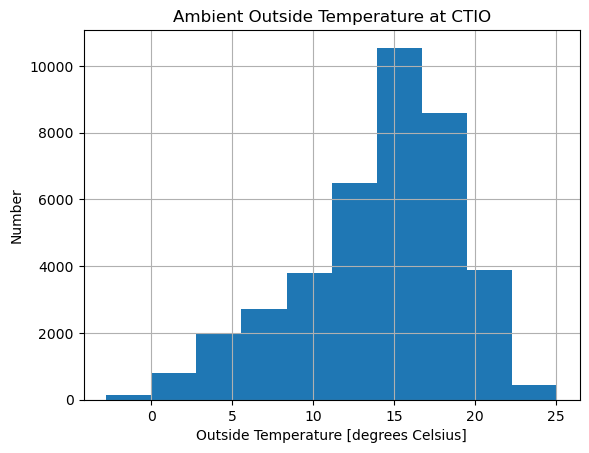

In [9]:
if df_all_1 is not None:
    df_all_1.hist(datumLabel1)
    plt.title('Ambient Outside Temperature at CTIO')
    plt.xlabel('Outside Temperature [degrees Celsius]')
    plt.ylabel('Number')


In [10]:
end_time = end_time_0

In [11]:
df_list = []

In [12]:
for n in range(n_steps + 1):

    start_time = end_time - timedelta(days=date_interval)

    print(n, start_time, end_time)

    start = start_time.isoformat(timespec='seconds') + 'Z' # Add 'Z' for UTC
    end = end_time.isoformat(timespec='seconds') + 'Z'

    # Construct the URL
    url = f'https://weather-api.lco.global/query?site={site}&datumname={datumname2}&start={start}&end={end}'

    # Run query
    data = None
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        data = response.json()
        #print(data)
    except requests.exceptions.RequestException as e:
        print(f"Error making request: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response content: {e.response.text}")


    # Convert results to pandas dataframe
    
    if data: # Ensure data was successfully fetched
    
        try:
            df = pd.DataFrame(data)

            # Assuming the JSON structure is a list of dictionaries,
            # where each dictionary represents a data point.
            # Common keys might be 'timestamp', 'value', 'units', etc.

            # Example: Convert 'timestamp' column to datetime objects
            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])

            # Example: Set 'timestamp' as the index (optional, but often useful for time series)
            if 'timestamp' in df.columns:
                df = df.set_index('timestamp')

            if 'Value' in df.columns:
                df = df.rename(columns={'Value': datumLabel2})
            
            #print(df.head()) # Display the first few rows of the DataFrame
            #print(df.info()) # Get a summary of the DataFrame

            df_list.append(df)

        except Exception as e:
            print(f"Error converting JSON to DataFrame: {e}")
            # It's helpful to print the structure of 'data' here if conversion fails
            print(f"Structure of data: {type(data)} - {data[:2] if isinstance(data, list) else data}")

    else:
        print("No data received from the API to convert to DataFrame.")

    end_time = start_time

if len(df_list) > 1:
    df_all_2 = pd.concat(df_list, ignore_index=True)
elif len(df_list) == 1:
    df_all_2 = df_list[0]
else:
    print("No DataFrames to concatenate.")
    df_all_2 = None

0 2025-05-09 22:49:42.024955 2025-05-29 22:49:42.024955
1 2025-04-19 22:49:42.024955 2025-05-09 22:49:42.024955
2 2025-03-30 22:49:42.024955 2025-04-19 22:49:42.024955
3 2025-03-10 22:49:42.024955 2025-03-30 22:49:42.024955
4 2025-02-18 22:49:42.024955 2025-03-10 22:49:42.024955
5 2025-01-29 22:49:42.024955 2025-02-18 22:49:42.024955
No data received from the API to convert to DataFrame.
6 2025-01-09 22:49:42.024955 2025-01-29 22:49:42.024955
No data received from the API to convert to DataFrame.
7 2024-12-20 22:49:42.024955 2025-01-09 22:49:42.024955
8 2024-11-30 22:49:42.024955 2024-12-20 22:49:42.024955
9 2024-11-10 22:49:42.024955 2024-11-30 22:49:42.024955
10 2024-10-21 22:49:42.024955 2024-11-10 22:49:42.024955
11 2024-10-01 22:49:42.024955 2024-10-21 22:49:42.024955
12 2024-09-11 22:49:42.024955 2024-10-01 22:49:42.024955
13 2024-08-22 22:49:42.024955 2024-09-11 22:49:42.024955
14 2024-08-02 22:49:42.024955 2024-08-22 22:49:42.024955
15 2024-07-13 22:49:42.024955 2024-08-02 22:4

In [13]:
if df_all_2 is not None:
    display(df_all_2.head())

,TimeStamp,Cloudiness,ValueString,TimeStampMeasured
0,2025/05/09 22:45:00,-17.503448,,2025/05/09 22:45:00
1,2025/05/09 23:00:00,-17.048124,,2025/05/09 23:00:00
2,2025/05/09 23:15:00,-17.678106,,2025/05/09 23:15:00
3,2025/05/09 23:30:00,-18.548235,,2025/05/09 23:30:00
4,2025/05/09 23:45:00,-18.111515,,2025/05/09 23:45:00


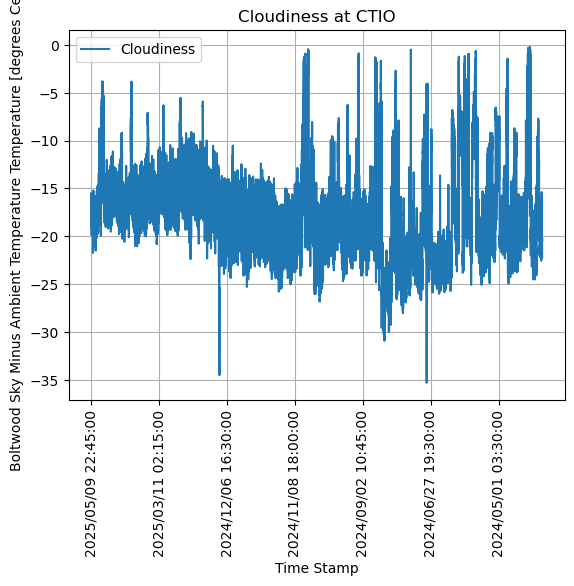

In [14]:
if df_all_2 is not None:
    df_all_2.plot('TimeStamp', datumLabel2)
    plt.title('Cloudiness at CTIO')
    plt.xticks(rotation=90) # This is the key line!
    plt.xlabel('Time Stamp')
    plt.ylabel('Boltwood Sky Minus Ambient Temperature Temperature [degrees Celsius]')
    plt.grid(True)

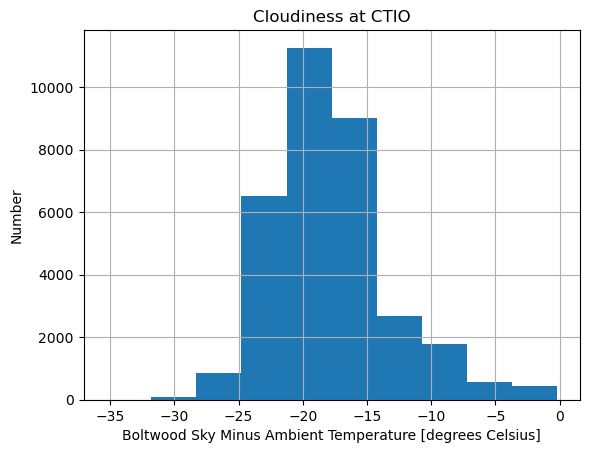

In [15]:
if df_all_2 is not None:
    df_all_2.hist(datumLabel2)
    plt.title('Cloudiness at CTIO')
    plt.xlabel('Boltwood Sky Minus Ambient Temperature [degrees Celsius]')
    plt.ylabel('Number')


In [16]:
final_df = pd.concat([df_all_1, df_all_2], axis=1, join='outer')

In [17]:
final_df

,TimeStamp,Temperature,ValueString,TimeStampMeasured,TimeStamp,Cloudiness,ValueString,TimeStampMeasured
0,2025/05/09 22:45:00,14.910000,,2025/05/09 22:45:00,2025/05/09 22:45:00,-17.503448,,2025/05/09 22:45:00
1,2025/05/09 23:00:00,15.373333,,2025/05/09 23:00:00,2025/05/09 23:00:00,-17.048124,,2025/05/09 23:00:00
2,2025/05/09 23:15:00,15.350000,,2025/05/09 23:15:00,2025/05/09 23:15:00,-17.678106,,2025/05/09 23:15:00
3,2025/05/09 23:30:00,15.405556,,2025/05/09 23:30:00,2025/05/09 23:30:00,-18.548235,,2025/05/09 23:30:00
4,2025/05/09 23:45:00,15.445455,,2025/05/09 23:45:00,2025/05/09 23:45:00,-18.111515,,2025/05/09 23:45:00
...,...,...,...,...,...,...,...,...
39366,2024/04/24 21:45:00,16.966667,,2024/04/24 21:45:00,NaN,NaN,NaN,NaN
39367,2024/04/24 22:00:00,16.355555,,2024/04/24 22:00:00,NaN,NaN,NaN,NaN
39368,2024/04/24 22:15:00,16.012500,,2024/04/24 22:15:00,NaN,NaN,NaN,NaN
39369,2024/04/24 22:30:00,15.787500,,2024/04/24 22:30:00,NaN,NaN,NaN,NaN


<Axes: xlabel='Temperature', ylabel='Cloudiness'>

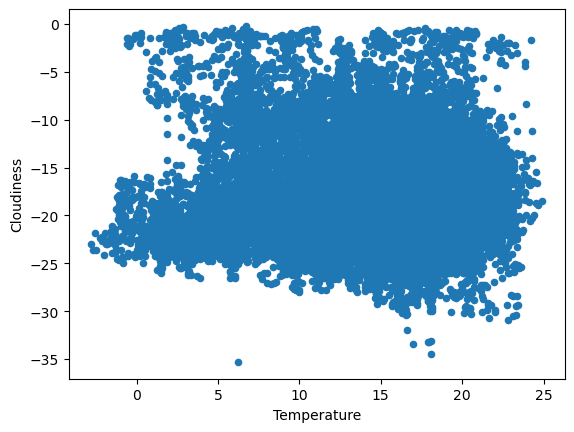

In [18]:
final_df.plot('Temperature', 'Cloudiness', kind='scatter')

<Axes: xlabel='Temperature', ylabel='Cloudiness'>

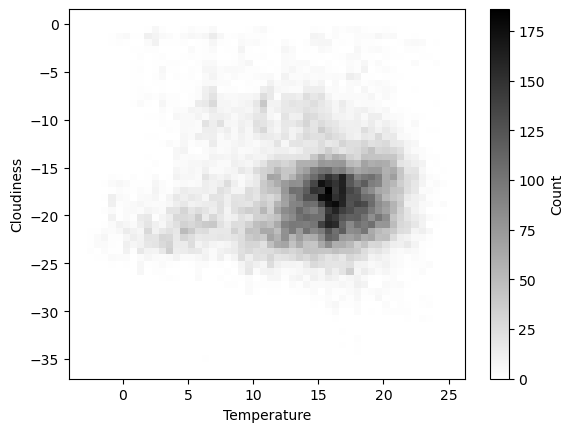

In [19]:
sns.histplot(data=final_df, x='Temperature', y='Cloudiness',
             bins=(50, 50), # Number of bins for x and y axes
             cmap='grey_r',
             cbar=True, # Show the color bar
             cbar_kws={'label': 'Count'}) # Label for the color bar

In [ ]:
'Boltwood Sky Minus Ambient Temperature'

In [ ]:
sns.histplot(data=final_df, x='Temperature', y='Cloudiness',
             bins=(50, 50), # Number of bins for x and y axes
             cmap='grey_r',
             cbar=True, # Show the color bar
             cbar_kws={'label': 'Count'}) # Label for the color bar